# Parameter rankings from CLM5.0 PPE

- create rankings of parameters that have greatest change in a given variable under CO2 and climate forcing
    - ΔCO2 = C867 - C285
    - Δclimate = AF2095 - AF1855
- focus on ET
- global mean and Whittaker biomes

# Code origin
Some of the code in this notebook is directly copied or modified from Claire Zarakas' code for the coupled CESM PPE which itself was developed from Daniel Kennedy's code for the CLM5.0 PPE

Claire Zarakas on Github: https://github.com/czarakas/coupled_PPE/blob/main/code/01_select_parameters/Part1_Coupled_PPE_param_selection.ipynb

Daniel Kennedy on Github: https://github.com/djk2120/CLM5PPE/blob/master/pyth/param_selection.ipynb

# NOTE:
- Need to redo the biome calculations for all variables, expect for `['EFLX_LH_TOT', 'FCTR', 'FCEV', 'FGEV', 'LH_TOT_derived']`

# 1. Setup

In [3]:
%load_ext watermark
%load_ext autoreload

import glob
import copy
import pickle

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt

import cmocean.cm as cmo

import sys
sys.path.append('/glade/u/home/bbuchovecky/projects/cpl_ppe_co2/utils')
import cpl_ppe_co2 as ppe
%aimport cpl_ppe_co2
%autoreload 1

%watermark -iv -co -v

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

conda environment: cpl_ppe_co2

cmocean   : 4.0.3
matplotlib: 3.9.1
sys       : 3.12.4 | packaged by conda-forge | (main, Jun 17 2024, 10:23:07) [GCC 12.3.0]
pandas    : 2.2.2
xarray    : 2024.6.0
numpy     : 2.0.1



In [4]:
mpl.rcParams['figure.dpi'] = 120

## 1.1. Dask

Only need if loading PPE output as Datasets or computing rankings

In [5]:
# Create Dask cluster and client, scale up to 20 workers
cluster, client = ppe.get_ClusterClient(walltime='02:00:00')
cluster.scale(20)

In [6]:
## Check the status of the cluster
# client

## Prints the PBS job script that is used to submit the Dask workers
# print(cluster.job_script())

## Lists active workers and their status
cluster.workers

## Lists current jobs in Casper queue
# !qstat -u $USER

{'PBSCluster-13': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-19': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-10': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-1': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-9': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-7': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-18': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-0': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-16': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-17': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-11': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-8': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-15': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-4': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-2': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-3': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-5':

## 1.2 Load color dictionary

In [7]:
with open('mcolors.pkl', 'rb') as file:
    mcolors = pickle.load(file)

with open('./top26_param_colors.pkl', 'rb') as f:
    pscs26 = pickle.load(f)

with open('./top12_param_colors.pkl', 'rb') as f:
    pscs12 = pickle.load(f)

Text(0.5, 1.0, 'psc26 [n=26]')

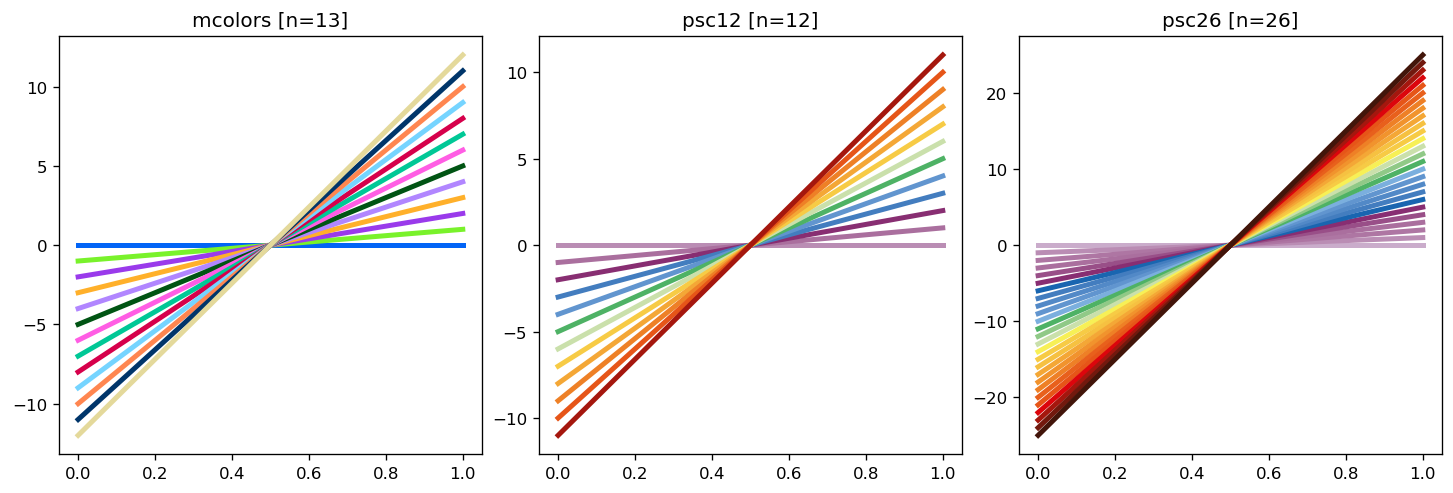

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(12,4), layout='constrained')
ax = axs.flatten()

colors = [v[1] for v in list(mcolors.items())]
for i,c in enumerate(colors):
    ax[0].plot([0,1],[-i,i], color=c, label=str(i), lw=3)
ax[0].set_title(f'mcolors [n={len(mcolors)}]')

colors = [v[1] for v in list(pscs12.items())]
for i,c in enumerate(colors):
    ax[1].plot([0,1],[-i,i], color=c, label=str(i), lw=3)
ax[1].set_title(f'psc12 [n={len(pscs12)}]')

colors = [v[1] for v in list(pscs26.items())]
for i,c in enumerate(colors):
    ax[2].plot([0,1],[-i,i], color=c, label=str(i), lw=3)
ax[2].set_title(f'psc26 [n={len(pscs26)}]')

## 1.2. Functions

Basic utility functions for loading and manipulating the PPE output. Mostly from Daniel Kennedy / Claire Zarakas

In [9]:
def get_params(keys,paramkey):
    '''(Code from Daniel Kennedy)'''
    params=[]
    minmaxs=[]
    for key in keys:
        ix     = paramkey.key==key
        params.append(paramkey.param[ix].values[0])
        minmaxs.append(paramkey.minmax[ix].values[0])
    return params,minmaxs

In [10]:
def month_wts(nyears):
    '''(Code from Daniel Kennedy)'''
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [11]:
def get_ensemble(name, data_vars, htape, keys, paramkey):
    '''
    (Modified from coode from Daniel Kennedy)
    Returns a dataset comprising the given ensemble
    name  = 'CTL2020' or 'C285' or 'AF1905'
    data_vars, e.g. ['GPP','HR','AR']
    htape, e.g. 'h0' 0/1/2/3/4/5/7 available
    '''

    # define the directory structure and find files
    topdir = '/glade/campaign/cgd/tss/projects/PPE/PPEn11_OAAT/'
    thisdir = topdir+name+'/hist/'
    files = [glob.glob(thisdir+'*'+key+'*'+htape+'*.nc')[0] for key in keys]

    def preprocess(ds):
        return ds[data_vars]

    # read in the dataset
    ds = xr.open_mfdataset(files, combine='nested', concat_dim='ens', parallel=True, preprocess=preprocess)

    # fix up time dimension
    if htape == 'h0':
        ds['time'] = xr.cftime_range(str(2005), periods=120, freq='MS')  # fix time bug

    # add in some extra variables
    ds0 = xr.open_dataset(files[0])
    extras = ['grid1d_lat', 'grid1d_lon']
    for extra in extras:
        ds[extra] = ds0[extra]

    # append some info about key/param/minmax
    params, minmaxs = get_params(keys, paramkey)
    ds['key'] = xr.DataArray(keys, dims='ens')
    ds['param'] = xr.DataArray(params, dims='ens')
    ds['minmax'] = xr.DataArray(minmaxs, dims='ens')

    whit = xr.open_dataset('./whit/whitkey.nc')
    ds['biome'] = whit['biome']
    ds['biome_name'] = whit['biome_name']

    return ds

In [12]:
def calc_mean(ds, datavar):
    '''(Code from Claire Zarakas, modified from code from Daniel Kennedy)'''
    cf = cfs[datavar]
    x = ds[datavar]

    da_ann = cf*(month_wts(10)*(la*x).sum(dim='gridcell')).groupby('time.year').sum(dim='time').compute()
    da_mean = da_ann.mean(dim='year')

    return da_mean, da_ann

In [13]:
def calc_iav(ds, datavar, da_ann=[]):
    '''(Code from Claire Zarakas, modified from code from Daniel Kennedy)'''
    # Compute da_ann if not provided
    if len(da_ann) == 0:
        cf = cfs[datavar]
        x = ds[datavar]
        da_ann = cf*(month_wts(10)*(la*x).sum(dim='gridcell')).groupby('time.year').sum(dim='time').compute()
    da_iav = da_ann.std(dim='year')
    return da_iav

In [14]:
def top_n(da, nx, params, minmax, uniques):
    '''(Code from Daniel Kennedy)'''
    xmins = []
    xmaxs = []
    dxs = []
    for u in uniques:
        pair = find_pair(da, params, minmax, u)
        xmin = pair[0].values
        xmax = pair[1].values
        dx = abs(xmax-xmin)

        xmins.append(xmin)
        xmaxs.append(xmax)
        dxs.append(dx)

    ranks = np.argsort(dxs)

    pvals = [uniques[ranks[i]] for i in range(-nx, 0)]
    xmins = [xmins[ranks[i]] for i in range(-nx, 0)]
    xmaxs = [xmaxs[ranks[i]] for i in range(-nx, 0)]

    return xmins, xmaxs, pvals

In [15]:
def find_pair(da, params, minmax, p):
    '''
    (Code from Daniel Kennedy)
    returns a subset of da, corresponding to parameter-p
        the returned pair corresponds to [p_min,p_max]
    '''
    ixmin = np.logical_and(params == p, minmax == 'min')
    ixmax = np.logical_and(params == p, minmax == 'max')

    # sub in default if either is missing
    if ixmin.sum().values == 0:
        ixmin = params == 'default'
    if ixmax.sum().values == 0:
        ixmax = params == 'default'

    emin = da.ens.isel(ens=ixmin).values[0]
    emax = da.ens.isel(ens=ixmax).values[0]

    return da.sel(ens=[emin, emax])

## 1.3. Load data
I copied the parameter key file and the sparsegrid land area file into my local directory.

In [16]:
# Get the key for which parameters correspond to which ensemble members
# '/glade/u/home/djk2120/oaat_clm5_ppe/pyth/survkey.csv' -> no key column
# '/glade/u/home/djk2120/oaat_clm5_ppe/pyth/depr/surv2.csv'
# '/glade/u/home/czarakas/coupled_PPE/code/01_select_parameters/deprecated/surv.csv' -> same as Daniel's version
paramkey_csv = './surv.csv'
paramkey = pd.read_csv(paramkey_csv)

# Get the sparsegrid land area
# '/glade/u/home/djk2120/oaat_clm5_ppe/pyth/sparsegrid_landarea.nc'
la_nc = './sparsegrid_landarea.nc'
la = xr.open_dataset(la_nc).landarea  # gridcell km2

Should use Dask for the following

In [17]:
%%time

# Choose variables of interest
data_vars = [
    'EFLX_LH_TOT',               # evapotranspiration (total latent heat flux, units W/m2)
    # 'FSH',                       #  sensible heat flux
    # 'QVEGT','QVEGE','QSOIL',     # transpiration, canopy evaporation, soil evaporation
    'FCTR', 'FCEV', 'FGEV',      # canopy transpiration, canopy evaporation, soil evaporation (component latent heat flux, units W/m2)
    # 'FSR', 'FSDS',               # absorbed solar radiation, downwelling solar radiation
    # 'TSA', 'TSKIN',              # 2m air temperature, skin temperature
    # 'Q2M',                       # 2m specific humidity
    # 'U10', 'TAUX', 'TAUY',       # 10m zonal wind, zonal wind stress, meridional wind stress
    # 'GPP', 'HR', 'AR',           # gross primary production, total heterotrophic respiration, total autotrophic respiration
    # 'NEE', 'NEP', 'NBP', 'NPP',  # net ecosystem exchange, net ecosystem production, net biome production, net primary production
]

keys = paramkey.key
nens = len(keys)

# Read in the dataset
ds_ctl = get_ensemble('CTL2010', data_vars, 'h0', keys, paramkey)
ds_c285 = get_ensemble('C285', data_vars, 'h0', keys, paramkey)
ds_c867 = get_ensemble('C867', data_vars, 'h0', keys, paramkey)
ds_af1855 = get_ensemble('AF1855', data_vars, 'h0', keys, paramkey)
ds_af2095 = get_ensemble('AF2095', data_vars, 'h0', keys, paramkey)

CPU times: user 17.9 s, sys: 4.33 s, total: 22.2 s
Wall time: 1min 36s


In [18]:
# Calculate new variables (if needed)
for ds in [ds_ctl, ds_c285, ds_c867, ds_af1855, ds_af2095]:
    # # ALBEDO_allSW = FSR / FSDS
    # assert ds['FSR'].attrs['units'] == ds['FSDS'].attrs['units']
    # ds['ALBEDO_allSW'] = ds['FSR'] / ds['FSDS']
    # ds['ALBEDO_allSW'].attrs['units'] = 'unitless'

    # # ET = QVEGT + QVEGE + QSOIL
    # assert ds['QVEGT'].attrs['units'] == ds['QVEGE'].attrs['units'] == ds['QSOIL'].attrs['units']
    # ds['ET'] = ds['QVEGT'] + ds['QVEGE'] + ds['QSOIL']
    # ds['ET'].attrs['units'] = ds['QVEGT'].attrs['units']

    # LH = FCTR + FCEV + FGEV
    assert ds['FCTR'].attrs['units'] == ds['FCEV'].attrs['units'] == ds['FGEV'].attrs['units']
    ds['LH_TOT_derived'] = ds['FCTR'] + ds['FCEV'] + ds['FGEV']
    ds['LH_TOT_derived'].attrs['units'] = ds['FCTR'].attrs['units']

# data_vars = data_vars + ['ALBEDO_allSW', 'ET']
data_vars = data_vars + ['LH_TOT_derived']

print(data_vars)

['EFLX_LH_TOT', 'FCTR', 'FCEV', 'FGEV', 'LH_TOT_derived']


In [19]:
ds = ds_ctl # choose which ensemble to use, doesn't matter for now

cfs = dict()    # conversion factors
units = dict()  # units

# Intensives (need to account for land area)
lasum = la.sum()
for field in data_vars:
    cfs[field]   = 1 / lasum / 365
    units[field] = ds[field].attrs['units']

ppe.save_dict({key: item.item() for key, item in cfs.items()}, 'cfs.csv')
ppe.save_dict(units, 'units.csv')

saved cfs.csv
saved units.csv


In [20]:
# Get unique parameters, excluding 'default'
uniques = list(np.unique(ds.param))
uniques.remove('default')

# Store the parameter names and minmax across ensemble (mask-like)
params = ds.param
minmax = ds.minmax

### Parameter look up
The following is the master csv file with each parameter name and description. Useful for looking up what the parameter does.

In [21]:
df = pd.read_csv('/glade/u/home/djk2120/oaat_clm5_ppe/pyth/params_c220517.csv')

In [ ]:
df.loc[df['name']=='jmaxse_sf']['Description'].values

In [ ]:
df.loc[df['name']=='kn_nonmyc']['Description'].values

In [ ]:
df.loc[df['name']=='tpuse_sf']['Description'].values

In [ ]:
df.loc[df['name']=='psi50']['Description'].values

# 2. Calculate parameter rankings

## 2.1. *Global Mean*

### 2.1.1. Computations
Already computed - no need to run again

#### - Save default parameter values for each scenario

In [21]:
%%time

params_topn = []
params_biome = []
params_forcing = []
params_criteria = []
params_variable = []
params_measure = []
params_x =[]

for ds in [ds_ctl, ds_c285, ds_c867, ds_af1855, ds_af2095]:
    ds_id = ds.attrs['case_id'].split('_')[1]
    ds = ds.sel(ens=0)
    print(f'\n--- {ds_id} ---')

    for datavar in data_vars:
        print(datavar, end=', ')
        [da_mean, da_ann] = calc_mean(ds, datavar)
        params_topn = params_topn+['default']
        params_biome = params_biome+['global']
        params_forcing = params_forcing+[ds_id]
        params_criteria = params_criteria+[datavar+'_MEAN_global']
        params_variable = params_variable+[datavar]
        params_measure = params_measure+['mean']
        params_x = params_x+[da_mean.values]
        
        iav = calc_iav(ds, datavar, da_ann=da_ann)
        params_topn = params_topn+['default']
        params_biome = params_biome+['global']
        params_forcing = params_forcing+[ds_id]
        params_criteria = params_criteria+[datavar+'_IAV_global']
        params_variable = params_variable+[datavar]
        params_measure = params_measure+['iav']
        params_x = params_x+[iav.values]
print()

df_global = pd.DataFrame({'param_name': params_topn, 
                          'biome':      params_biome,
                          'forcing':    params_forcing,
                          'criteria':   params_criteria, 
                          'variable':   params_variable,
                          'measure':    params_measure,
                          'x':          params_x,})
df_global.to_csv(f'./rank/csv/default_params.csv', index=False)


--- CTL2010 ---
EFLX_LH_TOT, FCTR, FCEV, FGEV, LH_TOT_derived, 
--- C285 ---
EFLX_LH_TOT, FCTR, FCEV, FGEV, LH_TOT_derived, 
--- C867 ---
EFLX_LH_TOT, FCTR, FCEV, FGEV, LH_TOT_derived, 
--- AF1855 ---
EFLX_LH_TOT, FCTR, FCEV, FGEV, LH_TOT_derived, 
--- AF2095 ---
EFLX_LH_TOT, FCTR, FCEV, FGEV, LH_TOT_derived, 
CPU times: user 4.95 s, sys: 184 ms, total: 5.13 s
Wall time: 10.3 s


#### - Create and save parameter ranks for each scenario

In [22]:
%%time

cutoff_num = len(uniques)  # takes ~20 min to run with Dask cluster

for ds in [ds_ctl, ds_c285, ds_c867, ds_af1855, ds_af2095]:
# for ds in [ds_ctl]:
    ds_id = ds.attrs['case_id'].split('_')[1]
    print(f'--- {ds_id} ---')

    params_topn = []
    params_biome = []
    params_criteria = []
    params_rank = []
    params_variable = []
    params_measure = []
    params_xmax = []
    params_xmin = []
    params_range = []

    for datavar in data_vars:
        print(datavar)
        [da_mean,da_ann] = calc_mean(ds, datavar)
        iav = calc_iav(ds, datavar, da_ann=da_ann)
        
        # Mean
        [xmins,xmaxs,pvals] = top_n(da_mean,cutoff_num,params,minmax,uniques)
        pvals.reverse()
        xmins.reverse()
        xmaxs.reverse()
        params_topn = params_topn + pvals[0:cutoff_num]
        params_biome = params_biome+['global']*cutoff_num
        params_criteria = params_criteria+[datavar+'_MEAN_global']*cutoff_num
        params_rank = params_rank+np.arange(1,cutoff_num+1).tolist()
        params_variable = params_variable+[datavar]*cutoff_num
        params_measure = params_measure+['mean']*cutoff_num
        params_xmax = params_xmax + xmaxs
        params_xmin = params_xmin + xmins
        params_range = params_range + [abs(xmins[i]-xmaxs[i]) for i in range(cutoff_num)]

        # IAV
        [xmins,xmaxs,pvals] = top_n(iav,cutoff_num,params,minmax,uniques)
        pvals.reverse()
        xmins.reverse()
        xmaxs.reverse()
        params_topn = params_topn + pvals[0:cutoff_num]
        params_biome = params_biome+['global']*cutoff_num
        params_criteria = params_criteria+[datavar+'_IAV_global']*cutoff_num
        params_rank = params_rank+np.arange(1,cutoff_num+1).tolist()
        params_variable = params_variable+[datavar]*cutoff_num
        params_measure = params_measure+['iav']*cutoff_num
        params_xmax = params_xmax + xmaxs
        params_xmin = params_xmin + xmins
        params_range = params_range + [abs(xmins[i]-xmaxs[i]) for i in range(cutoff_num)]
    
    # Create dictionary of lists 
    df_global = pd.DataFrame({'param_name': params_topn, 
                              'biome':      params_biome, 
                              'criteria':   params_criteria, 
                              'rank':       params_rank,
                              'variable':   params_variable,
                              'measure':    params_measure,
                              'xmin':       params_xmin,
                              'xmax':       params_xmax,
                              'range':      params_range,})
    df_global.to_csv(f'./rank/csv/{ds_id}_top{cutoff_num}_params.csv', index=False)

--- CTL2010 ---
EFLX_LH_TOT
FCTR
FCEV
FGEV
LH_TOT_derived
--- C285 ---
EFLX_LH_TOT
FCTR
FCEV
FGEV
LH_TOT_derived
--- C867 ---
EFLX_LH_TOT
FCTR
FCEV
FGEV
LH_TOT_derived
--- AF1855 ---
EFLX_LH_TOT
FCTR
FCEV
FGEV
LH_TOT_derived
--- AF2095 ---
EFLX_LH_TOT
FCTR
FCEV
FGEV
LH_TOT_derived
CPU times: user 4min 37s, sys: 9.17 s, total: 4min 46s
Wall time: 6min 59s


In [23]:
# pd.read_csv(f'./rank/csv/CTL2010_top193_params.csv')

#### - Compute the parameter ranks for differences between scenarios

In [47]:
def rank_diff(v, ssp, pi, do_biomes=False, save=False):
    ftag = ''
    if do_biomes:
        ftag = '_biomes'      
    
    df_ssp = pd.read_csv(f'./rank/csv/{ssp}_top193_params{ftag}.csv')
    df_pi = pd.read_csv(f'./rank/csv/{pi}_top193_params{ftag}.csv')

    df_ssp = df_ssp.loc[df_ssp['variable']==v]
    df_pi = df_pi.loc[df_pi['variable']==v]
    
    biomes = df_ssp['biome'].unique()
    assert all(df_pi['biome'].unique() == biomes)
    assert all(df_pi['param_name'].sort_values().values == df_ssp['param_name'].sort_values().values)

    param_name = []
    biome = []
    criteria = []
    variable = []
    measure = []
    ssp_rank = []
    ssp_range = []
    pi_rank = []
    pi_range = []
    diff_range = []
    diff_rank = []

    for bm in biomes:
        # Compute rankings for difference in mean
        mean_ssp = df_ssp[df_ssp['measure']=='mean'].loc[df_ssp['biome']==bm].sort_values(by='param_name', ascending=True, inplace=False).reset_index(drop=True)  # align order of parameters
        mean_pi = df_pi[df_pi['measure']=='mean'].loc[df_pi['biome']==bm].sort_values(by='param_name', ascending=True, inplace=False).reset_index(drop=True)      # align order of parameters
        mean_diff = abs(mean_ssp['range'] - mean_pi['range'])  # calculate the difference
        mean_diff_rank = mean_diff.argsort()[::-1].reset_index(drop=True).argsort()+1  # rank the differences

        # Compute rankings for difference in iav
        iav_ssp = df_ssp[df_ssp['measure']=='iav'].loc[df_ssp['biome']==bm].sort_values(by='param_name', ascending=True, inplace=False).reset_index(drop=True)  # align order of parameters
        iav_pi = df_pi[df_pi['measure']=='iav'].loc[df_pi['biome']==bm].sort_values(by='param_name', ascending=True, inplace=False).reset_index(drop=True)      # align order of parameters
        iav_diff = abs(iav_ssp['range'] - iav_pi['range'])  # calculate the difference
        iav_diff_rank = iav_diff.argsort()[::-1].reset_index(drop=True).argsort()+1  # rank the differences

        # Combine the dataframes
        param_name += mean_ssp['param_name'].tolist() + iav_ssp['param_name'].tolist()
        biome += mean_ssp['biome'].tolist() + iav_ssp['biome'].tolist()
        criteria += mean_ssp['criteria'].tolist() + iav_ssp['criteria'].tolist()
        variable += mean_ssp['variable'].tolist() + iav_ssp['variable'].tolist()
        measure += mean_ssp['measure'].tolist() + iav_ssp['measure'].tolist()
        ssp_rank += mean_ssp['rank'].tolist() + iav_ssp['rank'].tolist()
        ssp_range += mean_ssp['range'].tolist() + iav_ssp['range'].tolist()
        pi_rank += mean_pi['rank'].tolist() + iav_pi['rank'].tolist()
        pi_range += mean_pi['range'].tolist() + iav_pi['range'].tolist()
        diff_range += mean_diff.tolist() + iav_diff.tolist()
        diff_rank += mean_diff_rank.tolist() + iav_diff_rank.tolist()

    df_diff = pd.DataFrame({'param_name': param_name,
                            'biome': biome,
                            'criteria': criteria,
                            'variable': variable,
                            'measure': measure,
                            'ssp_rank': ssp_rank,
                            'ssp_range': ssp_range,
                            'pi_rank': pi_rank,
                            'pi_range': pi_range,
                            'diff_range': diff_range,
                            'diff_rank': diff_rank})

    df_diff = df_diff.sort_values(by=['biome', 'measure', 'diff_rank']).reset_index(drop=True)

    if save:
        if len(biomes) > 1:
            fname = f'./rank/csv/{v}_top193_{ssp}_{pi}_diff_params_biomes.csv'
        else:
            fname = f'./rank/csv/{v}_top193_{ssp}_{pi}_diff_params.csv'
        df_diff.to_csv(fname, index=False)
        print(fname)
        
    return df_diff

In [48]:
%%time

for var in data_vars:
    rank_diff(var, 'AF2095', 'AF1855', save=True);
    rank_diff(var, 'C867', 'C285', save=True);
    rank_diff(var, 'C867', 'CTL2010', save=True);
    rank_diff(var, 'AF2095', 'CTL2010', save=True);

./rank/csv/EFLX_LH_TOT_top193_AF2095_AF1855_diff_params.csv
./rank/csv/EFLX_LH_TOT_top193_C867_C285_diff_params.csv
./rank/csv/EFLX_LH_TOT_top193_C867_CTL2010_diff_params.csv
./rank/csv/EFLX_LH_TOT_top193_AF2095_CTL2010_diff_params.csv
./rank/csv/FCTR_top193_AF2095_AF1855_diff_params.csv
./rank/csv/FCTR_top193_C867_C285_diff_params.csv
./rank/csv/FCTR_top193_C867_CTL2010_diff_params.csv
./rank/csv/FCTR_top193_AF2095_CTL2010_diff_params.csv
./rank/csv/FCEV_top193_AF2095_AF1855_diff_params.csv
./rank/csv/FCEV_top193_C867_C285_diff_params.csv
./rank/csv/FCEV_top193_C867_CTL2010_diff_params.csv
./rank/csv/FCEV_top193_AF2095_CTL2010_diff_params.csv
./rank/csv/FGEV_top193_AF2095_AF1855_diff_params.csv
./rank/csv/FGEV_top193_C867_C285_diff_params.csv
./rank/csv/FGEV_top193_C867_CTL2010_diff_params.csv
./rank/csv/FGEV_top193_AF2095_CTL2010_diff_params.csv
./rank/csv/LH_TOT_derived_top193_AF2095_AF1855_diff_params.csv
./rank/csv/LH_TOT_derived_top193_C867_C285_diff_params.csv
./rank/csv/LH_TOT_

In [57]:
# rank_diff('EFLX_LH_TOT', 'AF2095', 'AF1855', save=True);

In [59]:
# rank_diff('EFLX_LH_TOT', 'C867', 'C285', save=True);

In [60]:
# rank_diff('EFLX_LH_TOT', 'C867', 'CTL2010', save=True);

In [61]:
# rank_diff('EFLX_LH_TOT', 'AF2095', 'CTL2010', save=True);

### 1.1.2. Plotting functions

In [28]:
def plot_indv_diffrange_topn(v, ssp, pi, top, save=False):
    '''
    Plot the top n parameters with the greatest the
    difference in parameter range between two scenarios
    '''
    if 'units' not in locals():
        units = ppe.load_dict('units.csv')

    if glob.glob(f'./rank/csv/{v}_top193_{ssp}_{pi}_diff_params.csv'):
        df = pd.read_csv(f'./rank/csv/{v}_top193_{ssp}_{pi}_diff_params.csv')
    else:
        df = rank_diff(v, ssp, pi, save=True)

    df = df.loc[df['variable']==v].loc[df['measure']=='mean']
    df = df.sort_values(by='diff_rank').reset_index(drop=True)
    df = df.head(top)[::-1]

    fig, ax = plt.subplots(figsize=(6, 6))
    for tt in range(top):
        pi_label = None
        ssp_label = None
        if tt == 0:
            pi_label = f'{pi} range'
            ssp_label = f'{ssp} range'
        ax.plot((df['pi_range'].iloc[tt], df['ssp_range'].iloc[tt]), (tt, tt), 'r-')
        ax.plot(df['pi_range'].iloc[tt], tt, 'ro', markerfacecolor='white', label=pi_label)
        ax.plot(df['ssp_range'].iloc[tt], tt, 'ro', label=ssp_label)
    ax.axvline(0, color='black', linewidth=mpl.rcParams['axes.linewidth'], zorder=0)
    ax.legend()
    ax.set_xlabel(f'{v} [{units[v]}]')
    ax.set_yticks(np.arange(top))
    ax.set_yticklabels(df['param_name'])
    ax.set_xlabel(f'{v}')

    if save:
        plt.show()
        fig.savefig(f'./rank/fig/{v}_top{top}_params_diffrange.png', dpi=300)

In [29]:
def plot_diffrange_topn(v, top, save=False):
    '''
    Plot the top n parameters with the greatest the
    difference in parameter range between two scenarios
    '''
    if 'units' not in locals():
        units = ppe.load_dict('units.csv')

    # Get AF scenarios
    if glob.glob(f'./rank/csv/{v}_top193_AF2095_AF1855_diff_params.csv'):
        df_a = pd.read_csv(f'./rank/csv/{v}_top193_AF2095_AF1855_diff_params.csv')
    else:
        df_a = rank_diff(v, 'AF2095', 'AF1855', save=True)

    # Get C scenarios
    if glob.glob(f'./rank/csv/{v}_top193_C867_C285_diff_params.csv'):
        df_c = pd.read_csv(f'./rank/csv/{v}_top193_C867_C285_diff_params.csv')
    else:
        df_c = rank_diff(v, 'C867', 'C285', save=True)

    # Select the variable
    df_a = df_a.loc[df_a['variable']==v]
    df_c = df_c.loc[df_c['variable']==v]

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for ii, (ss, df) in enumerate(zip(['AF2095-AF1855', 'C867-C285'], [df_a, df_c])):
        for jj, mm in enumerate(['mean', 'iav']):
            tmp = df.loc[df['measure']==mm].sort_values(by='diff_rank').reset_index(drop=True)
            tmp = tmp.head(top)[::-1]

            for tt in range(top):
                pi_label = None; ssp_label = None
                if tt == 0:
                    pi_label = ss.split('-')[1]
                    ssp_label = ss.split('-')[0]
                axes[jj, ii].plot((tmp['pi_range'].iloc[tt], tmp['ssp_range'].iloc[tt]), (tt, tt), 'r-')
                axes[jj, ii].plot(tmp['pi_range'].iloc[tt], tt, 'ro', markerfacecolor='white', label=pi_label)
                axes[jj, ii].plot(tmp['ssp_range'].iloc[tt], tt, 'ro', label=ssp_label)

            axes[jj, ii].axvline(0, color='black', linewidth=mpl.rcParams['axes.linewidth'], zorder=0)

            axes[jj, ii].set_yticks(np.arange(top))
            axes[jj, ii].set_yticklabels(tmp['param_name'])
            axes[jj, ii].set_xlabel(f'{v} [{units[v]}]')
            axes[jj, ii].set_title(f'{ss} {mm}')

            plt.subplots_adjust(wspace=1)
            plt.subplots_adjust(hspace=0.25)
        
    if save:
        fig.savefig(f'./rank/fig/{v}_top{top}_params_diffrange.png', dpi=300)
        plt.close();

In [30]:
def plot_indv_topn(v, top, save=False):
    ''' Plot the top n parameters for each forcing scenario'''
    if 'units' not in locals():
        units = ppe.load_dict('units.csv')

    forc = ['CTL2010', 'C285', 'C867', 'AF1855', 'AF2095']
    fig, axes = plt.subplots(2, 5, figsize=(20, 6))
    for ii, f in enumerate(forc):
        for jj, m in enumerate(['mean', 'iav']):
            df = pd.read_csv(f'./rank/csv/{f}_top193_params.csv')
            tmp = df.loc[df['variable']==v].loc[df['measure']==m].sort_values(by='rank')[:top]
            tmp = tmp[::-1]

            for tt in range(top):
                axes[jj, ii].plot((tmp['xmin'].iloc[tt], tmp['xmax'].iloc[tt]), (tt, tt), 'r-')
                axes[jj, ii].plot(tmp['xmin'].iloc[tt], tt, 'ro', markerfacecolor='white')
                axes[jj, ii].plot(tmp['xmax'].iloc[tt], tt, 'ro')

            axes[jj, ii].set_yticks(range(top))
            axes[jj, ii].set_yticklabels(tmp['param_name'], fontsize=8)
            axes[jj, ii].set_xlabel(f'{v} [{units[v]}]')
            axes[jj, ii].set_title(f'{f} {m}')

    plt.subplots_adjust(hspace=0.3)
    plt.subplots_adjust(wspace=1.6)

    if save:
        fig.savefig(f'./rank/fig/{v}_indv_top{top}_params_range.png', dpi=300)
        plt.close();

In [31]:
def plot_topn(v, top, figw=12, figh=8, figws=0.6, fighs=0.2, sharex=True, save=False):
    ''' Plot the top n parameters for a given variable v '''
    if 'units' not in locals():
        units = ppe.load_dict('units.csv')

    fig = plt.figure(figsize=(figw, figh))
    gs = fig.add_gridspec(2, 2, hspace=fighs, wspace=figws)

    if sharex:
        axmean1 = fig.add_subplot(gs[0, 0])
        axmean2 = fig.add_subplot(gs[0, 1], sharex=axmean1)
        axiav1 = fig.add_subplot(gs[1, 0])
        axiav2 = fig.add_subplot(gs[1, 1], sharex=axiav1)
        axes = np.array([[axmean1, axmean2], [axiav1, axiav2]])
    if not sharex:
        axmean1 = fig.add_subplot(gs[0, 0])
        axmean2 = fig.add_subplot(gs[0, 1])
        axiav1 = fig.add_subplot(gs[1, 0])
        axiav2 = fig.add_subplot(gs[1, 1])
        axes = np.array([[axmean1, axmean2], [axiav1, axiav2]])

    forc = ['CTL2010', 'C285', 'C867', 'AF1855', 'AF2095']
    col = ['black', 'tab:blue', 'tab:orange']

    # Variables for y-ticks
    dytk = 0.3*top/2.5
    space = 1.25*top/2.5
    ytk = [[i]*3 for i in np.arange(0,top*space+np.finfo(float).eps,space)]
    ytk = np.array((np.array([0, 1, 2])*dytk).tolist() * top) + np.array([x for xs in ytk for x in xs])

    for jj, m in enumerate(['mean', 'iav']):
        ii = 0
        ylb = [0] * top * 3
        for xx, f in enumerate(['CTL2010', 'C285', 'C867']):
            df = pd.read_csv(f'./rank/csv/{f}_top193_params.csv')
            tmp = df.loc[df['variable']==v].loc[df['measure']==m].sort_values(by='rank')[:top]
            tmp = tmp[::-1]

            for tt in range(top):
                ylb[xx+tt*3] = tmp['param_name'].iloc[tt]
                axes[jj, ii].plot((tmp['xmin'].iloc[tt], tmp['xmax'].iloc[tt]), (ytk[xx+tt*3], ytk[xx+tt*3]), '-', color=col[xx])
                axes[jj, ii].plot(tmp['xmin'].iloc[tt], ytk[xx+tt*3], 'o', markerfacecolor='white', markeredgecolor=col[xx])
                axes[jj, ii].plot(tmp['xmax'].iloc[tt], ytk[xx+tt*3], 'o', markerfacecolor=col[xx], markeredgecolor=col[xx])

        axes[jj, ii].set_yticks(ytk)
        axes[jj, ii].set_yticklabels(ylb, fontsize=7)
        axes[jj, ii].set_title(f'C {m}')

        ii = 1
        ylb = [0] * top * 3
        for xx, f in enumerate(['CTL2010', 'AF1855', 'AF2095']):
            df = pd.read_csv(f'./rank/csv/{f}_top193_params.csv')
            tmp = df.loc[df['variable']==v].loc[df['measure']==m].sort_values(by='rank')[:top]
            tmp = tmp[::-1]
        
            for tt in range(top):
                ylb[xx+tt*3] = tmp['param_name'].iloc[tt]
                axes[jj, ii].plot((tmp['xmin'].iloc[tt], tmp['xmax'].iloc[tt]), (ytk[xx+tt*3], ytk[xx+tt*3]), '-', color=col[xx])
                axes[jj, ii].plot(tmp['xmin'].iloc[tt], ytk[xx+tt*3], 'o', markerfacecolor='white', markeredgecolor=col[xx])
                axes[jj, ii].plot(tmp['xmax'].iloc[tt], ytk[xx+tt*3], 'o', markerfacecolor=col[xx], markeredgecolor=col[xx])

        axes[jj, ii].set_yticks(ytk)
        axes[jj, ii].set_yticklabels(ylb, fontsize=7)
        axes[jj, ii].set_title(f'AF {m}')

    axes[1,0].set_xlabel(f'{v} [{units[v]}]')
    axes[1,1].set_xlabel(f'{v} [{units[v]}]')

    fig.suptitle(f'{v} global parameter ranking\nC=carbon forcing, AF=atmospheric forcing\norange=SSP3-7.0, blue=PI, black=CTL2010')

    if save:
        fig.savefig(f'./rank/fig/{v}_top{top}_params_range.png', dpi=300)
        plt.close();

### 2.1.3. Plots

In [32]:
%%time
top = 8
# for v in ['EFLX_LH_TOT', 'FSH', 'ALBEDO_allSW', 'TSA', 'Q2M']:
for v in data_vars:
    plot_diffrange_topn(v, top, save=True)
    plot_indv_topn(v, top, save=True)
    plot_topn(v, top, sharex=True, save=True)

CPU times: user 13.6 s, sys: 969 ms, total: 14.6 s
Wall time: 14.7 s


## 2.2. *Whittaker biomes*

Use the CTL2010 biome regions for all forcings

### 2.2.1. Computations
Already computed - no need to run again

In [30]:
# @njit  # numba: set "nopython" mode for best performance
def calc_mean_biome(dsb, datavar, lab, env, save_preload=False, use_preload=True):
    '''
    Add dosctring
    '''
    domain = 'biome'
    preload = '/glade/work/bbuchovecky/CPL_PPE_CO2/select_parameters/biome/'+env+'_'+datavar+'_'+domain+'.nc'

    if len(glob.glob(preload)) > 0:
        print('  [biome mean and iav exist on disk]')

    # Calculate the mean and IAV for each biome
    if not glob.glob(preload) or not use_preload:
        print('  [calculating biome mean and iav]')
    
        # for intrinsic variables, use biome land area
        # (do this as default for all variables)
        cf = 1 / (lab.groupby('biome').sum() * month_wts(1).sum())
        x = dsb[datavar]

        # calc annual mean or sum (determined by cf)
        xann = cf * (month_wts(10) * (lab * x).groupby('biome').sum() ).groupby('time.year').sum().compute()

        # average/iav
        xm = xann.mean(dim='year')
        iav = xann.std(dim='year')

        # save the reduced data
        out = xr.Dataset()
        out[datavar+'_mean'] = xm
        out[datavar+'_mean'].attrs = {'units': units[datavar]}
        out[datavar+'_iav'] = iav
        out[datavar+'_iav'].attrs = {'units': units[datavar]}
        out['param'] = dsb.param
        out['minmax'] = dsb.minmax

        print('  [done calculating biome mean and iav]')

        if save_preload:
            print('  [saving biome mean and iav to disk]')
            out.load().to_netcdf(preload)

    # Load from file if available
    elif glob.glob(preload) and use_preload:
        out = xr.open_dataset(preload)
        print('  [loaded biome mean and iav from disk]')

    xm = out[datavar+'_mean']
    iav = out[datavar+'_iav']

    return xm, iav

In [22]:
## test case

# cf = cfs['EFLX_LH_TOT']

# la['biome'] = ds['biome']
# lab = la.swap_dims({'gridcell':'biome'})

# dsb = ds_af2095.swap_dims({'gridcell':'biome'})
# x = dsb['EFLX_LH_TOT']

# xann = cf * (month_wts(10) * (lab * x).groupby('biome').sum() ).groupby('time.year').sum().compute()

# labsum = la.groupby('biome').sum()
# annsum = month_wts(1).sum()
# xannb = (month_wts(10) * (lab * x).groupby('biome').sum() ).groupby('time.year').sum() / (labsum * annsum)
# xannb = xannb.compute()

#### - Save default parameter values for each scenario

In [31]:
%%time

la['biome'] = ds['biome']
lab = la.swap_dims({'gridcell':'biome'})

params_topn = []
params_biome = []
params_forcing = []
params_criteria = []
params_variable = []
params_measure = []
params_x =[]

for ds in [ds_ctl, ds_c285, ds_c867, ds_af1855, ds_af2095]:
    env = ds.attrs['case_id'].split('_')[1]
    print(f'--- {env} ---')

    dsb = ds.swap_dims({'gridcell':'biome'})

    for datavar in data_vars:
        print(datavar)
        da, iav = calc_mean_biome(dsb, datavar, lab, env, use_preload=False, save_preload=True)

        for i in np.arange(0, 10):
            b = str(dsb.biome_name.isel(biome_id=i).values)
            print(f'  {b}')

            params_topn = params_topn+['default']
            params_biome = params_biome+[b]
            params_forcing = params_forcing+[env]
            params_criteria = params_criteria+[da.name+'_'+b]
            params_variable = params_variable+[datavar]
            params_measure = params_measure+['mean']
            params_x = params_x+[da.sel(biome=i,ens=0).values]

            params_topn = params_topn+['default']
            params_biome = params_biome+[b]
            params_forcing = params_forcing+[env]
            params_criteria = params_criteria+[iav.name+'_'+b]
            params_variable = params_variable+[datavar]
            params_measure = params_measure+['iav']
            params_x = params_x+[iav.sel(biome=i,ens=0).values]

df_biomes = pd.DataFrame({'param_name': params_topn, 
                          'biome':      params_biome,
                          'forcing':    params_forcing,
                          'criteria':   params_criteria, 
                          'variable':   params_variable,
                          'measure':    params_measure,
                          'x':          params_x,})
df_biomes.to_csv(f'./rank/csv/default_params_biomes.csv', index=False)

--- CTL2010 ---
EFLX_LH_TOT
  [calculating biome mean and iav]
  [done calculating biome mean and iav]
  [saving biome mean and iav to disk]
  Ice sheet
  Tropical rain forest
  Tropical seasonal forest/savanna
  Subtropical desert
  Temperate rain forest
  Temperate seasonal forest
  Woodland/shrubland
  Temperate grassland/desert
  Boreal forest
  Tundra
FCTR
  [calculating biome mean and iav]
  [done calculating biome mean and iav]
  [saving biome mean and iav to disk]
  Ice sheet
  Tropical rain forest
  Tropical seasonal forest/savanna
  Subtropical desert
  Temperate rain forest
  Temperate seasonal forest
  Woodland/shrubland
  Temperate grassland/desert
  Boreal forest
  Tundra
FCEV
  [calculating biome mean and iav]
  [done calculating biome mean and iav]
  [saving biome mean and iav to disk]
  Ice sheet
  Tropical rain forest
  Tropical seasonal forest/savanna
  Subtropical desert
  Temperate rain forest
  Temperate seasonal forest
  Woodland/shrubland
  Temperate grassland/d

#### - Create and save parameter ranks for each scenario

In [32]:
%%time

cutoff_num = len(uniques)  # takes ~90 min to run with Dask cluster

print('cutoff number:', cutoff_num)
print('variables:', data_vars)

la['biome'] = ds['biome']
lab = la.swap_dims({'gridcell':'biome'})

for ds in [ds_ctl, ds_c285, ds_c867, ds_af1855, ds_af2095]:
    env = ds.attrs['case_id'].split('_')[1]
    print(f'--- {env} ---')

    dsb = ds.swap_dims({'gridcell':'biome'})

    params_top5 = []
    params_biome = []
    params_criteria = []
    params_rank = []
    params_variable = []
    params_measure = []
    params_xmax = []
    params_xmin = []
    params_range = []

    uniques = list(np.unique(ds.param))
    uniques.remove('default')

    for datavar in data_vars:
        print(datavar)
        da, iav = calc_mean_biome(dsb, datavar, lab, env, use_preload=True, save_preload=False)

        for i in np.arange(0, 10):
            b = str(dsb.biome_name.isel(biome_id=i).values)
            print(f'  {b}')

            [xmins, xmaxs, pvals] = top_n(da.isel(biome=i), cutoff_num, params, minmax, uniques)
            pvals.reverse()
            xmins.reverse()
            xmaxs.reverse()
            params_top5 = params_top5 + pvals[0:cutoff_num]
            params_biome = params_biome+[b]*cutoff_num
            params_criteria = params_criteria+[da.name+'_'+b]*cutoff_num
            params_rank = params_rank+np.arange(1, cutoff_num+1).tolist()
            params_variable = params_variable+[datavar]*cutoff_num
            params_measure = params_measure+['mean']*cutoff_num
            params_xmax = params_xmax + xmaxs
            params_xmin = params_xmin + xmins
            params_range = params_range + [abs(xmins[i]-xmaxs[i]) for i in range(cutoff_num)]

            [xmins, xmaxs, pvals] = top_n(iav.isel(biome=i), cutoff_num, params, minmax, uniques)
            pvals.reverse()
            xmins.reverse()
            xmaxs.reverse()
            params_top5 = params_top5 + pvals[0:cutoff_num]
            params_biome = params_biome+[b]*cutoff_num
            params_criteria = params_criteria+[iav.name+'_'+b]*cutoff_num
            params_rank = params_rank+np.arange(1, cutoff_num+1).tolist()
            params_variable = params_variable+[datavar]*cutoff_num
            params_measure = params_measure+['iav']*cutoff_num
            params_xmax = params_xmax + xmaxs
            params_xmin = params_xmin + xmins
            params_range = params_range + [abs(xmins[i]-xmaxs[i]) for i in range(cutoff_num)]

    # Create dictionary of lists 
    df_biomes = pd.DataFrame({'param_name': params_top5, 
                              'biome':      params_biome, 
                              'criteria':   params_criteria, 
                              'rank':       params_rank,
                              'variable':   params_variable,
                              'measure':    params_measure,
                              'xmin':       params_xmin,
                              'xmax':       params_xmax,
                              'range':      params_range,})
    df_biomes.to_csv(f'./rank/csv/{env}_top{cutoff_num}_params_biomes.csv', index=False)

cutoff number: 193
variables: ['EFLX_LH_TOT', 'FCTR', 'FCEV', 'FGEV', 'LH_TOT_derived']
--- CTL2010 ---
EFLX_LH_TOT
  [biome mean and iav exist on disk]
  [loaded biome mean and iav from disk]
  Ice sheet
  Tropical rain forest
  Tropical seasonal forest/savanna
  Subtropical desert
  Temperate rain forest
  Temperate seasonal forest
  Woodland/shrubland
  Temperate grassland/desert
  Boreal forest
  Tundra
FCTR
  [biome mean and iav exist on disk]
  [loaded biome mean and iav from disk]
  Ice sheet
  Tropical rain forest
  Tropical seasonal forest/savanna
  Subtropical desert
  Temperate rain forest
  Temperate seasonal forest
  Woodland/shrubland
  Temperate grassland/desert
  Boreal forest
  Tundra
FCEV
  [biome mean and iav exist on disk]
  [loaded biome mean and iav from disk]
  Ice sheet
  Tropical rain forest
  Tropical seasonal forest/savanna
  Subtropical desert
  Temperate rain forest
  Temperate seasonal forest
  Woodland/shrubland
  Temperate grassland/desert
  Boreal fores

#### - Compute the parameter ranks for differences between scenarios

In [35]:
for v in data_vars:
    rank_diff(v, 'AF2095', 'AF1855', do_biomes=True, save=True);
    rank_diff(v, 'C867', 'C285', do_biomes=True, save=True);
    rank_diff(v, 'AF2095', 'CTL2010', do_biomes=True, save=True);
    rank_diff(v, 'C867', 'CTL2010', do_biomes=True, save=True);

./rank/csv/EFLX_LH_TOT_top193_AF2095_AF1855_diff_params_biomes.csv
./rank/csv/EFLX_LH_TOT_top193_C867_C285_diff_params_biomes.csv
./rank/csv/EFLX_LH_TOT_top193_AF2095_CTL2010_diff_params_biomes.csv
./rank/csv/EFLX_LH_TOT_top193_C867_CTL2010_diff_params_biomes.csv
./rank/csv/FCTR_top193_AF2095_AF1855_diff_params_biomes.csv
./rank/csv/FCTR_top193_C867_C285_diff_params_biomes.csv
./rank/csv/FCTR_top193_AF2095_CTL2010_diff_params_biomes.csv
./rank/csv/FCTR_top193_C867_CTL2010_diff_params_biomes.csv
./rank/csv/FCEV_top193_AF2095_AF1855_diff_params_biomes.csv
./rank/csv/FCEV_top193_C867_C285_diff_params_biomes.csv
./rank/csv/FCEV_top193_AF2095_CTL2010_diff_params_biomes.csv
./rank/csv/FCEV_top193_C867_CTL2010_diff_params_biomes.csv
./rank/csv/FGEV_top193_AF2095_AF1855_diff_params_biomes.csv
./rank/csv/FGEV_top193_C867_C285_diff_params_biomes.csv
./rank/csv/FGEV_top193_AF2095_CTL2010_diff_params_biomes.csv
./rank/csv/FGEV_top193_C867_CTL2010_diff_params_biomes.csv
./rank/csv/LH_TOT_derived_to

### 2.2.2. Plotting functions

In [36]:
def plot_biome_diffrange_topn(v, ssp, pi, top, measure, save=False):
    '''
    Add docstring
    '''
    if 'units' not in locals():
        units = ppe.load_dict('units.csv')

    fname = f'./rank/csv/{v}_top193_{ssp}_{pi}_diff_params_biomes.csv'
    if glob.glob(fname):
        df = pd.read_csv(fname)
    else:
        df = rank_diff(v, ssp, pi, do_biomes=True, save=True)

    # Select the variable and mean or iav
    df = df.loc[df['variable']==v].loc[df['measure']==measure]

    # Create figure and axes
    fig, axes = plt.subplots(3, 3, figsize=(14, 10))
    ax = axes.flatten()

    # Get the unique biomes and ignore ice sheet
    biomes = df['biome'].unique().tolist()
    biomes.remove('Ice sheet')

    for ii, bm in enumerate(biomes):
        tmp = df.loc[df['biome']==bm].sort_values(by='diff_rank').head(top)[::-1]

        # Iterate thhrough the top rankings
        for tt in range(top):
            pi_label = None
            ssp_label = None
            if tt == 0:
                pi_label = pi
                ssp_label = ssp
            ax[ii].plot((tmp['pi_range'].iloc[tt], tmp['ssp_range'].iloc[tt]), (tt, tt), 'r-')
            ax[ii].plot(tmp['pi_range'].iloc[tt], tt, 'ro', markerfacecolor='white', label=pi_label)
            ax[ii].plot(tmp['ssp_range'].iloc[tt], tt, 'ro', label=ssp_label)
        
        ax[ii].axvline(0, color='black', linewidth=mpl.rcParams['axes.linewidth'], zorder=0)
        ax[ii].set_yticks(np.arange(top))
        ax[ii].set_yticklabels(tmp['param_name'])
        ax[ii].set_xlabel(f'{v} range [{units[v]}]')
        ax[ii].set_title(f'{bm}', fontweight='bold')
        ax[ii].legend(loc='lower right')

    plt.suptitle(f'{v} top {top} parameters\n{ssp} - {pi}, {measure}, difference between parameter ranges', y=0.95)
    plt.subplots_adjust(hspace=0.375)
    plt.subplots_adjust(wspace=1.1)

    if save:
        fig.savefig(f'./rank/fig/{v}_{measure}_top{top}_{ssp}_{pi}_diffrange_biomes.png', dpi=300)
        plt.close();

### 2.2.3. Plots

In [37]:
%%time
for (ssp, pi) in zip(['AF2095', 'C867'], ['AF1855', 'C285']):
    for m in ['mean', 'iav']:
        for v in data_vars:
            plot_biome_diffrange_topn(v, ssp, pi, 8, m, save=True);

EFLX_LH_TOT
['Boreal forest', 'Ice sheet', 'Subtropical desert', 'Temperate grassland/desert', 'Temperate rain forest', 'Temperate seasonal forest', 'Tropical rain forest', 'Tropical seasonal forest/savanna', 'Tundra', 'Woodland/shrubland']
FCTR
['Boreal forest', 'Ice sheet', 'Subtropical desert', 'Temperate grassland/desert', 'Temperate rain forest', 'Temperate seasonal forest', 'Tropical rain forest', 'Tropical seasonal forest/savanna', 'Tundra', 'Woodland/shrubland']
FCEV
['Boreal forest', 'Ice sheet', 'Subtropical desert', 'Temperate grassland/desert', 'Temperate rain forest', 'Temperate seasonal forest', 'Tropical rain forest', 'Tropical seasonal forest/savanna', 'Tundra', 'Woodland/shrubland']
FGEV
['Boreal forest', 'Ice sheet', 'Subtropical desert', 'Temperate grassland/desert', 'Temperate rain forest', 'Temperate seasonal forest', 'Tropical rain forest', 'Tropical seasonal forest/savanna', 'Tundra', 'Woodland/shrubland']
LH_TOT_derived
['Boreal forest', 'Ice sheet', 'Subtropica

## 2.3. *Global hotspot coupling*
TBD

# 3. Select top parameters

## 3.1. Visualization

### 3.1.1. Individual plots

In [38]:
def plot_distr(
    v, m, s, biome=None, ndiff=10, plim=100,
    do_hist=True, color_diff=False,
    add_cbar=True, return_cbar=False,
    add_vlines=True, add_text=False,
    fig=None, ax=None, save=False):
    '''
    Add dosctring
    '''
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    def get_discrete_colors(cmap_name, n):
        cmap = plt.get_cmap(cmap_name)
        colors = [cmap(i) for i in np.linspace(0.15, 0.85, n)]
        return colors

    # Load units if not already loaded
    if 'units' not in locals():
        units = ppe.load_dict('units.csv')

    # Modify plim (hacky fix for now)
    plim += 1
    
    # Create modifier if plotting biome
    bm = ''
    if biome is not None:
        bm = '_biomes'

    # Load the data
    if '_' in s:
        color_diff = False
        df = pd.read_csv(f'./rank/csv/{v}_top193_{s}_diff_params{bm}.csv')
        rng = 'diff_range'
        rnk = 'diff_rank'
        pmn = 'pi_range'
        pmx = 'ssp_range'
    else:
        df = pd.read_csv(f'./rank/csv/{s}_top193_params{bm}.csv')
        df_def = pd.read_csv(f'./rank/csv/default_params{bm}.csv')
        defx = df_def['x'].loc[df_def['variable']==v].loc[df_def['measure']==m].loc[df_def['forcing']==s]
        rng = 'range'
        rnk = 'rank'
        pmn = 'xmin'
        pmx = 'xmax'

    # Select the variable and measure, and filter by biome if provided
    if biome is not None:
        df = df.loc[df['variable']==v].loc[df['measure']==m].loc[df['biome']==biome].sort_values(by=rnk)
        defx = defx.loc[df_def['biome']==biome]
    elif biome is None:
        df = df.loc[df['variable']==v].loc[df['measure']==m].sort_values(by=rnk)

    # Total number of parameters
    nparam = len(df)

    # Create figure and axes if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot the histogram of parameter ranges with min=0
    if do_hist:
        ax.bar(np.arange(plim)+1, df[rng].loc[df[rnk]<=plim], width=1, facecolor='darkgray', linewidth=0)
        ax.set_ylim(0, max(df[rng].loc[df[rnk]<=plim])+0.2*max(df[rng].loc[df[rnk]<=plim]))

        # Add lines for percentiles (approx top 20 (90%), 10 (95%), 5 (97.5%) parameters)
        if add_vlines:
            for pp in [0.90, 0.95, 0.975]:
                ax.plot(
                    [int((1-pp)*nparam)]*2,
                    [df.loc[df[rnk]==int((1-pp)*nparam+1)][rng].values[0], max(df[rng].loc[df[rnk]<=plim])+0.2*max(df[rng].loc[df[rnk]<=plim])],
                    c='k', ls='--', lw=0.8)
                ax.plot(
                    [-3, int((1-pp)*nparam)],
                    [df.loc[df[rnk]==int((1-pp)*nparam+1)][rng].values[0]]*2,
                    c='k', ls='--', lw=0.8)
                ax.text(
                    int((1-pp)*nparam), max(df[rng].loc[df[rnk]<=plim])+0.21*max(df[rng].loc[df[rnk]<=plim]), 
                    f'{int((1-pp)*nparam)+1}', va='bottom', ha='center', fontsize=8)

    # Plot the parameter ranges with true min and max
    elif not do_hist:
        mn = np.array([min(abs(row['xmin']), abs(row['xmax'])) for index, row in df.iterrows()])
        mx = np.array([max(abs(row['xmin']), abs(row['xmax'])) for index, row in df.iterrows()])
        amn = min(mn)
        amx = max(mx)
        ax.bar(np.arange(plim)+1, height=df[rng].loc[df[rnk]<=plim], bottom=mn[:plim], width=1, facecolor='darkgray', linewidth=0)
        ax.set_ylim(amn-(amx-amn)*0.15, max(mx)+(amx-amn)*0.1)
        if '_' not in s:
            ax.axhline(defx.values[0], c='black', ls='--', lw=mpl.rcParams['axes.linewidth']*1.5, zorder=300)

        # Add lines for percentiles (approx top 20 (90%), 10 (95%), 5 (97.5%) parameters)
        if add_vlines:
            for pp in [0.90, 0.95, 0.975]:
                ax.axvline(int((1-pp)*nparam), color='k', ls='--', lw=0.8)
                ax.text(
                    int((1-pp)*nparam), max(mx)+(amx-amn)*0.11,
                    f'{int((1-pp)*nparam)+1}', va='bottom', ha='center', fontsize=8)
        
        # Add histogram of parameter ranges at the bottom
        ax2 = ax.twinx()
        ax2.bar(np.arange(plim)+1, df[rng].loc[df[rnk]<=plim], width=1, facecolor='darkgray', linewidth=0)
        ymx = max(df[rng].loc[df[rnk]<=plim])
        ax2.axhline(ymx+0.1*ymx, color='black', linewidth=mpl.rcParams['axes.linewidth'], zorder=0)
        ax2.set_ylim(0, ymx+10*ymx)
        ax2.set_yticks([])

    # Label top n parameters
    if add_text and plim <= 51:
        # ax.text(0.25, 0.98, f'Rank by {s}:', transform=ax.transAxes, fontsize=8, fontweight='bold', va='top', ha='left')
        # for ii in range(ndiff):
        #     ax.text(
        #         0.25, 0.92-ii*0.0485,
        #         str(ii+1).ljust(3)+' '+df['param_name'].loc[df[rnk]==ii+1].values[0],
        #         transform=ax.transAxes,
        #         fontsize=8, va='center', ha='left')
        for ii in range(plim-1):
            ax.text(
                ii+1, ax.get_ylim()[1],
                f'{ii+1} {str(df["param_name"].loc[df[rnk]==ii+1].values[0])}',
                fontsize=8, va='top', ha='center', rotation=90)

    ax.set_xticks([1]+list(np.arange(0, plim+1, 5)[1:]))
    ax.set_xlim(-0.01*plim, plim-0.5)
    ax.set_xlabel(f'Rank by {s}')
    ax.set_ylabel(f'{v} [{units[v]}]')

    if biome is not None:
        ax.set_title(f'{s}, {v}, {biome}, {m}', loc='right')
    elif biome is None:
        ax.set_title(f'{s}, {v}, {m}', loc='right')

    # Add colorbar for the difference in parameter range between scenarios
    if color_diff:
        if s in ['AF2095', 'AF1855']:
            name = 'AF2095-AF1855'
            df_diff = pd.read_csv(f'./rank/csv/{v}_top193_AF2095_AF1855_diff_params{bm}.csv')
        if s in ['C867', 'C285']:
            name = 'C867-C285'
            df_diff = pd.read_csv(f'./rank/csv/{v}_top193_C867_C285_diff_params{bm}.csv')

        if s in ['AF2095', 'C867']:
            label = 'ssp'
        if s in ['AF1855', 'C285']:
            label = 'pi'

        if biome is not None:
            df_diff = df_diff.loc[df_diff['measure']==m].loc[df_diff['biome']==biome]
        if biome is None:
            df_diff = df_diff.loc[df_diff['measure']==m]
        df_diff = df_diff.sort_values(by='diff_rank', ascending=True, inplace=False).reset_index(drop=True)
        df_diff = df_diff.head(ndiff)

        cs = get_discrete_colors(cmo.matter_r, ndiff)

        if do_hist:
            ax.bar(df_diff[label+'_rank'], df_diff[label+'_range'], width=1, color=cs, linewidth=0)
        elif not do_hist:
            ax.bar(df_diff[label+'_rank'], height=df_diff[label+'_range'], bottom=mn[df_diff[label+'_rank']-1], width=1, color=cs, linewidth=0)
            ax2.bar(df_diff[label+'_rank'], height=df_diff[label+'_range'], width=1, color=cs, linewidth=0)

        if add_cbar:
            discrete_cmap = mpl.colors.ListedColormap(cs)
            norm = plt.Normalize(vmin=1, vmax=ndiff+1)
            sm = plt.cm.ScalarMappable(cmap=discrete_cmap, norm=norm)
            sm.set_array(df_diff['diff_rank'])

            if return_cbar:
                return sm

            else:
                cbax = inset_axes(
                    ax,
                    width="4%", height="50%", loc='upper right', borderpad=1,
                    bbox_to_anchor=(0, 0, 0.925, 0.975),
                    bbox_transform=ax.transAxes)
                cb = fig.colorbar(sm, cax=cbax)
                cb.ax.invert_yaxis()
                cb.set_ticks(df_diff['diff_rank']+0.5)
                cb.set_ticklabels(df_diff['diff_rank'], fontsize=8)
                ax.text(0.8, 0.98, f'Rank by {name}:', transform=ax.transAxes, fontsize=8, fontweight='bold', va='top', ha='center')

                for ii in range(ndiff):
                    ax.text(
                        0.85, 0.92-ii*0.0485,
                        df_diff['param_name'][ii],
                        transform=ax.transAxes,
                        fontsize=8, va='center', ha='right')
        
    if save and ax is None:
        fig.savefig(f'./rank/fig/compare_rank/{v}_{s}_{m}_rank_compare.png', dpi=300)
        plt.close();

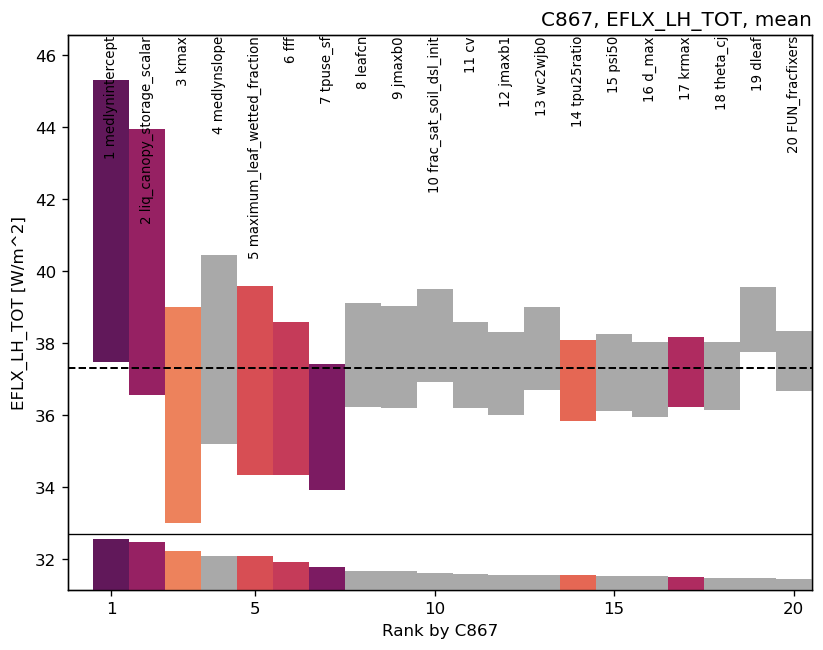

In [58]:
v = 'EFLX_LH_TOT'
m = 'mean'
s = 'C867'

plot_distr(
    v, m, s,
    biome=None,
    ndiff=10, plim=20,
    do_hist=False, color_diff=True, add_cbar=True, return_cbar=True,
    add_vlines=False, add_text=True, fig=None, ax=None, save=False
)

### 3.1.2. Panel plots

In [39]:
def plot_distr_panels(v, ssp, pi, save=False, **kwargs):
    '''
    Add dosctring
    '''
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), layout='tight')
    ax = axes.flatten()
    for ii, s in enumerate([ssp, pi]):
        for jj, m in enumerate(['mean', 'iav']):
            plot_distr(v, m, s, ax=axes[jj, ii], fig=fig, save=save, **kwargs)
    if save:
        fig.savefig(f'./rank/fig/compare_rank/{v}_{ssp}_{pi}_true_range.png', dpi=300)
        plt.close();

In [40]:
def plot_cbar_distr_panels(v, ssp, pi, ndiff, save=False, **kwargs):
    '''
    Add dosctring
    '''
    fig, axes = plt.subplots(3, 2, figsize=(12, 8), height_ratios=[1,1,0.1], layout='constrained')
    gs = axes[0, 0].get_gridspec()
    for ax in axes[2, :]:
        ax.remove()
    cax = fig.add_subplot(gs[2, :])

    for ii, s in enumerate([ssp, pi]):
        for jj, m in enumerate(['mean', 'iav']):
            sm = plot_distr(v, m, s, ndiff=ndiff, fig=fig, ax=axes[jj, ii], color_diff=True, add_cbar=True, return_cbar=True, save=save, **kwargs)
    cb = fig.colorbar(sm, cax=cax, orientation='horizontal')
    cb.ax.invert_yaxis()
    cb.set_ticks(np.arange(ndiff)+1.5)
    cb.set_ticklabels(np.arange(ndiff)+1, fontsize=10)
    cb.set_label(f'Rank by {ssp}-{pi}')
    if save:
        fig.savefig(f'./rank/fig/global_bars/{v}_{ssp}_{pi}.png', dpi=300)
        plt.close();

In [41]:
def plot_biome_distr_panels(v, s, m, ndiff, save=False, **kwargs):
    '''
    Add dosctring
    '''
    bms = ['Boreal forest', 'Subtropical desert',
           'Temperate grassland/desert', 'Temperate rain forest',
           'Temperate seasonal forest', 'Tropical rain forest',
           'Tropical seasonal forest/savanna', 'Tundra',
           'Woodland/shrubland']
    fig, axes = plt.subplots(4, 3, figsize=(16, 12), height_ratios=[1,1,1,0.1], layout='constrained')
    gs = axes[0, 0].get_gridspec()
    for ax in axes[3, :]:
        ax.remove()
    cax = fig.add_subplot(gs[3, :])
    ax = axes.flatten()[:-1]

    for ii, b in enumerate(bms):
        sm = plot_distr(v, m, s, biome=b, ndiff=ndiff, fig=fig, ax=ax[ii], color_diff=True, add_cbar=True, return_cbar=True, save=save, **kwargs)
    
    if s in ['AF2095', 'AF1855']:
        name = 'AF2095-AF1855'
    if s in ['C867', 'C285']:
        name = 'C867-C285'

    cb = fig.colorbar(sm, cax=cax, orientation='horizontal')
    cb.ax.invert_yaxis()
    cb.set_ticks(np.arange(ndiff)+1.5)
    cb.set_ticklabels(np.arange(ndiff)+1, fontsize=10)
    cb.set_label(f'Rank by {name}')
    if save:
        fig.savefig(f'./rank/fig/biome_bars/{v}_{s}_{m}_biomes.png', dpi=300)
        plt.close();

In [65]:
%%time
for ssp, pi in zip(['AF2095', 'C867'], ['AF1855', 'C285']):
    for v in ['EFLX_LH_TOT']:
        # plot_distr_panels(v, ssp, pi, do_hist=False, color_diff=True, save=True);
        plot_cbar_distr_panels(v, ssp, pi, ndiff=10, plim=20, do_hist=False, add_vlines=False, add_text=True, save=True);

CPU times: user 4.22 s, sys: 180 ms, total: 4.4 s
Wall time: 4.49 s


In [49]:
%%time
for ssp, pi in zip(['AF2095', 'C867'], ['AF1855', 'C285']):
    for v in data_vars:
        # plot_distr_panels(v, ssp, pi, do_hist=False, color_diff=True, save=True);
        plot_cbar_distr_panels(v, ssp, pi, ndiff=10, plim=20, do_hist=False, add_vlines=False, add_text=True, save=True);

CPU times: user 12.7 s, sys: 476 ms, total: 13.2 s
Wall time: 14.6 s


In [73]:
%%time
v = 'EFLX_LH_TOT'
for m in ['mean', 'iav']:
    for s in ['AF2095', 'AF1855', 'C867', 'C285']:
        plot_biome_distr_panels(v, s, m, ndiff=10, plim=20, do_hist=False, add_vlines=False, add_text=True, save=True)

CPU times: user 32 s, sys: 1.39 s, total: 33.4 s
Wall time: 32.9 s


In [53]:
%%time
for v in data_vars:
    for m in ['mean', 'iav']:
        for s in ['AF2095', 'AF1855', 'C867', 'C285']:
            plot_biome_distr_panels(v, s, m, ndiff=10, plim=20, do_hist=False, add_vlines=False, add_text=True, save=True)

CPU times: user 2min 8s, sys: 3.15 s, total: 2min 11s
Wall time: 2min 22s


## 3.2. Generate lists
**Method:**
1. global set
    1. top YY% of single scenario parameter range
    2. top YY% of inter-scenario parameter range
2. biome set
    1. top YY% of single scenario parameter range
    2. top YY% of inter-scenario parameter range
3. intersection of global and biome sets

### 3.2.1. Create master dataframe

In [51]:
kind = ['RNK', 'RNG']
meas = ['mean', 'iav']
forc = ['C285', 'C867', 'AF1855', 'AF2095', 'AF2095-AF1855', 'C867-C285']
biom = {
    'BF':    'Boreal forest',
    'SD':    'Subtropical desert',
    'TmGD':  'Temperate grassland/desert',
    'TmRF':  'Temperate rain forest',
    'TmSF':  'Temperate seasonal forest',
    'TrRF':  'Tropical rain forest',
    'TrSFS': 'Tropical seasonal forest/savanna',
    'Tu':    'Tundra',
    'WS':    'Woodland/shrubland',
    'GB':    'global',
}

# for v in ['EFLX_LH_TOT']:
for v in data_vars:
    col = []
    ii = 0
    data = np.zeros((193, len(kind)*len(meas)*len(forc)*len(biom)))
    for f in forc:
        for k in kind:
            for b in biom:
                for m in meas:
                    col.append(f'{k}_{f}_{b}_{m}')

                    # Get the correct label for range and rank
                    if '-' in f:
                        rnk = 'diff_rank'
                        rng = 'diff_range'
                    else:
                        rnk = 'rank'
                        rng = 'range'

                    # Load the data
                    if b == 'GB' and '-' not in f:
                        df = pd.read_csv(f'./rank/csv/{f}_top193_params.csv')
                    elif b == 'GB' and '-' in f:
                        df = pd.read_csv(f'./rank/csv/{v}_top193_{"_".join(f.split("-"))}_diff_params.csv')
                    elif b != 'GB' and '-' not in f:
                        df = pd.read_csv(f'./rank/csv/{f}_top193_params_biomes.csv')
                    else:
                        df = pd.read_csv(f'./rank/csv/{v}_top193_{"_".join(f.split("-"))}_diff_params_biomes.csv')
                    
                    # Filter the data
                    df = df.loc[df['variable']==v].loc[df['measure']==m].loc[df['biome']==biom[b]].sort_values(by='param_name').reset_index(drop=True)
                    
                    # Add the data to the array
                    data[:, ii] = df[rnk].values if k == 'RNK' else df[rng].values
                    ii += 1

    param_name = df['param_name'].values

    df_master = pd.DataFrame(data, columns=col)
    df_master.insert(0, 'param_name', param_name)
    for c in df_master.columns:
        if 'RNK' in c:
            df_master[c] = df_master[c].astype(int)
    df_master.to_csv(f'./rank/{v}_params_rank_all.csv', index=False)

### 3.2.1. Create lists of top parameters (using master dataframe)

In [11]:
v = 'EFLX_LH_TOT'
df = pd.read_csv(f'./rank/{v}_params_rank_all.csv')
key = list(df.columns[1:])

In [13]:
def OR_top(df, rank, forc=None, biome=None, measure=None, do_diff_forc=False):
    '''
    Select parameters that appear in one of the top Y rank of mean and iav at the global and biome level.
    (effectively a union)
    '''
    forc_list = ['AF2095', 'AF1855', 'C867', 'C285']
    if do_diff_forc:
        forc_list = forc_list + ['AF2095-AF1855', 'C867-C285']
    biome_list = ['BF', 'SD', 'TmGD', 'TmRF', 'TmSF', 'TrRF', 'TrSFS', 'Tu', 'WS', 'GB']
    param = set()

    if forc is not None and biome is not None:
        if measure is None:
            param = set(df.loc[df[f'RNK_{forc}_{biome}_mean']<=rank]['param_name'].tolist())
            param = param | set(df.loc[df[f'RNK_{forc}_{biome}_iav']<=rank]['param_name'].tolist())
        else:
            param = set(df.loc[df[f'RNK_{forc}_{biome}_{measure}']<=rank]['param_name'].tolist())

    elif forc is not None and biome is None:
        for bm in biome_list:
            if measure is None:
                param = param | set(df.loc[df[f'RNK_{forc}_{bm}_mean']<=rank]['param_name'].tolist())
                param = param | set(df.loc[df[f'RNK_{forc}_{bm}_iav']<=rank]['param_name'].tolist())
            else:
                param = set(df.loc[df[f'RNK_{forc}_{bm}_{measure}']<=rank]['param_name'].tolist())
    
    elif biome is not None and forc is None:
        for fc in forc_list:
            if measure is None:
                param = param | set(df.loc[df[f'RNK_{fc}_{biome}_mean']<=rank]['param_name'].tolist())
                param = param | set(df.loc[df[f'RNK_{fc}_{biome}_iav']<=rank]['param_name'].tolist())
            else:
                param = set(df.loc[df[f'RNK_{fc}_{biome}_{measure}']<=rank]['param_name'].tolist())
            
    else:
        for fc in forc_list:
            for bm in biome_list:
                if measure is None:
                    param = param | set(df.loc[df[f'RNK_{fc}_{bm}_mean']<=rank]['param_name'].tolist())
                    param = param | set(df.loc[df[f'RNK_{fc}_{bm}_iav']<=rank]['param_name'].tolist())
                else:
                    param = set(df.loc[df[f'RNK_{fc}_{bm}_{measure}']<=rank]['param_name'].tolist())
                
    return df.loc[df['param_name'].isin(param)]


def AND_top(df, rank, forc=None, biome=None, measure=None, do_diff_forc=False):
    '''
    Select parameters that appear in every top Y rank of mean and iav at the global and biome level.
    (effectively an intersection)
    '''
    forc_list = ['AF2095', 'AF1855', 'C867', 'C285']
    if do_diff_forc:
        forc_list = forc_list + ['AF2095-AF1855', 'C867-C285']
    biome_list = ['BF', 'SD', 'TmGD', 'TmRF', 'TmSF', 'TrRF', 'TrSFS', 'Tu', 'WS', 'GB']
    param = set(df['param_name'].tolist())

    if forc is not None and biome is not None:
        if measure is None:
            param = set(df.loc[df[f'RNK_{forc}_{bm}_mean']<=rank]['param_name'].tolist())
            param = param & set(df.loc[df[f'RNK_{forc}_{bm}_iav']<=rank]['param_name'].tolist())
        else:
            param = param & set(df.loc[df[f'RNK_{forc}_{bm}_{measure}']<=rank]['param_name'].tolist())

    elif forc is not None and biome is None:
        for bm in biome_list:
            if measure is None:
                param = param & set(df.loc[df[f'RNK_{forc}_{bm}_mean']<=rank]['param_name'].tolist())
                param = param & set(df.loc[df[f'RNK_{forc}_{bm}_iav']<=rank]['param_name'].tolist())
            else:
                param = param & set(df.loc[df[f'RNK_{forc}_{bm}_{measure}']<=rank]['param_name'].tolist())
    
    elif biome is not None and forc is None:
        for fc in forc_list:
            if measure is None:
                param = param & set(df.loc[df[f'RNK_{fc}_{biome}_mean']<=rank]['param_name'].tolist())
                param = param & set(df.loc[df[f'RNK_{fc}_{biome}_iav']<=rank]['param_name'].tolist())
            else:
                param = param & set(df.loc[df[f'RNK_{fc}_{biome}_{measure}']<=rank]['param_name'].tolist())
            
    elif biome is None and forc is None:
        for fc in forc_list:
            for bm in biome_list:
                if measure is None:
                    param = param & set(df.loc[df[f'RNK_{fc}_{bm}_mean']<=rank]['param_name'].tolist())
                    param = param & set(df.loc[df[f'RNK_{fc}_{bm}_iav']<=rank]['param_name'].tolist())
                else:
                    param = param & set(df.loc[df[f'RNK_{fc}_{bm}_{measure}']<=rank]['param_name'].tolist())
                
    return df.loc[df['param_name'].isin(param)]

We want to select parameters that appear in the top Y rank of mean and iav at the global and biome level, using a set intersection or union as the operator. Say we want to get 5 parameters that abide this rule using a set intersection, we can iterate through possible Y values (increasing) until we get have 5 parameters that are all in the top Y rank of the measure and global/biomes.

In [ ]:
forc = ['C285', 'C867', 'AF1855', 'AF2095', 'AF2095-AF1855', 'C867-C285']
param_lim = 5
inter_top = dict()

print(f'INTERSECTION\ntarget nparam = {param_lim}\n')
for fc in forc:
    print(f'--- {fc} ---')
    for nump in range(param_lim, 100):
        top = AND_top(df, nump, forc=fc)
        if len(top) >= param_lim:
            print(f'top {nump}: nparam = {len(top)}')
            print(sorted(top['param_name'].tolist()))
            inter_top[fc] = top
            break

print(f'--- all ---')
for nump in range(param_lim, 100):
    top = AND_top(df, nump, do_diff_forc=True)
    if len(top) >= param_lim:
        print(f'top {nump}: nparam = {len(top)}')
        print(sorted(top['param_name'].tolist()))
        break
inter_top['all'] = top

INTERSECTION
target nparam = 5

--- C285 ---
top 54: nparam = 5
['frac_sat_soil_dsl_init', 'liq_canopy_storage_scalar', 'medlynslope', 'theta_cj', 'wc2wjb0']
--- C867 ---
top 51: nparam = 5
['FUN_fracfixers', 'frac_sat_soil_dsl_init', 'jmaxb0', 'leafcn', 'wc2wjb0']
--- AF1855 ---
top 68: nparam = 5
['frac_sat_soil_dsl_init', 'krmax', 'leafcn', 'lmr_intercept_atkin', 'medlynslope']
--- AF2095 ---
top 59: nparam = 5
['csol_sand', 'lmr_intercept_atkin', 'lmrha', 'lmrhd', 'medlynslope']
--- AF2095-AF1855 ---
top 79: nparam = 5
['csol_sand', 'jmaxha', 'jmaxse_sf', 'kcha', 'medlynslope']
--- C867-C285 ---
top 73: nparam = 5
['cp25_yr2000', 'jmaxb0', 'liq_canopy_storage_scalar', 'maximum_leaf_wetted_fraction', 'medlynintercept']
--- all ---


We can do the same but use a set union as the operator so that the list is more inclusive. This means that parameters that appear in any of the top Y rank of mean and iav at the global and biome level will be included.

In [15]:
forc = ['C285', 'C867', 'AF1855', 'AF2095']#, 'AF2095-AF1855', 'C867-C285']
param_lim = 10
measure = None
biome = 'GB'

union_top = dict()

print('UNION')
for fc in forc:
    top = OR_top(df, param_lim, forc=fc, measure=measure, biome=biome)
    top = top.sort_values('param_name')
    print(f'\n--- {fc} ---')
    print(f'top {param_lim}: nparam = {len(top)}')
    for i in range(len(top)):
        print(top['param_name'].iloc[i]+',')
    union_top[fc] = top

top = OR_top(df, param_lim, do_diff_forc=False, measure=measure, biome=biome)
top = top.sort_values('param_name')
print('\n--- all ---')
print(f'top {param_lim}: nparam = {len(top)}')
for i in range(len(top)):
    print(top['param_name'].iloc[i]+',')
union_top['all'] = top

UNION

--- C285 ---
top 10: nparam = 17
baseflow_scalar,
cv,
d_max,
dleaf,
fff,
frac_sat_soil_dsl_init,
jmaxb0,
kmax,
kn_nonmyc,
krmax,
leafcn,
liq_canopy_storage_scalar,
maximum_leaf_wetted_fraction,
medlynintercept,
medlynslope,
sand_pf,
wc2wjb0,

--- C867 ---
top 10: nparam = 15
FUN_fracfixers,
d_max,
dleaf,
fff,
frac_sat_soil_dsl_init,
jmaxb0,
jmaxse_sf,
kmax,
leafcn,
liq_canopy_storage_scalar,
maximum_leaf_wetted_fraction,
medlynintercept,
medlynslope,
sand_pf,
tpuse_sf,

--- AF1855 ---
top 10: nparam = 17
FUN_fracfixers,
d_max,
fff,
frac_sat_soil_dsl_init,
jmaxb0,
kcha,
kmax,
krmax,
leafcn,
liq_canopy_storage_scalar,
lmrhd,
maximum_leaf_wetted_fraction,
medlynintercept,
medlynslope,
psi50,
sand_pf,
vcmaxhd,

--- AF2095 ---
top 10: nparam = 15
KCN,
csol_sand,
d_max,
fff,
frac_sat_soil_dsl_init,
jmaxb0,
kmax,
krmax,
liq_canopy_storage_scalar,
maximum_leaf_wetted_fraction,
medlynintercept,
medlynslope,
psi50,
sand_pf,
tpuse_sf,

--- all ---
top 10: nparam = 26
FUN_fracfixers,
KCN,
b

In [25]:
union_top['all'].sort_values(by='RNK_C285_GB_mean')

,param_name,RNK_C285_BF_mean,RNK_C285_BF_iav,RNK_C285_SD_mean,RNK_C285_SD_iav,RNK_C285_TmGD_mean,RNK_C285_TmGD_iav,RNK_C285_TmRF_mean,RNK_C285_TmRF_iav,RNK_C285_TmSF_mean,...,RNG_C867-C285_TrRF_mean,RNG_C867-C285_TrRF_iav,RNG_C867-C285_TrSFS_mean,RNG_C867-C285_TrSFS_iav,RNG_C867-C285_Tu_mean,RNG_C867-C285_Tu_iav,RNG_C867-C285_WS_mean,RNG_C867-C285_WS_iav,RNG_C867-C285_GB_mean,RNG_C867-C285_GB_iav
84,kmax,5,2,3,10,5,20,15,102,2,...,0.263327,0.003879,0.261112,0.007450,0.045025,0.001706,0.094229,0.001568,0.844828,0.003172
53,fff,10,9,1,3,1,6,76,88,25,...,0.022519,0.014827,0.828263,0.030449,0.098464,0.005233,0.188493,0.007587,1.444214,0.055541
106,medlynslope,1,1,6,5,6,3,5,28,1,...,0.003920,0.011643,0.156009,0.008139,0.050429,0.005672,0.023346,0.012389,0.140752,0.009915
94,liq_canopy_storage_scalar,6,3,17,16,14,32,14,17,7,...,0.500572,0.004081,1.646000,0.006926,0.110967,0.001036,0.315766,0.027637,3.303204,0.007798
105,medlynintercept,3,4,7,13,9,9,10,24,5,...,0.424863,0.014091,1.778332,0.021782,0.171649,0.005340,0.326163,0.028633,3.776434,0.038222
103,maximum_leaf_wetted_fraction,7,11,27,30,30,35,1,1,10,...,0.126071,0.014086,0.632519,0.034841,0.038618,0.000747,0.140821,0.005732,1.218241,0.014395
89,krmax,14,5,2,4,2,7,52,77,22,...,0.236276,0.000655,1.082490,0.001827,0.062525,0.000471,0.097598,0.000635,1.770895,0.000881
75,jmaxb0,2,6,24,7,7,1,3,2,3,...,0.037289,0.003672,0.171742,0.015332,0.006078,0.006475,0.278023,0.029575,0.514652,0.025788
92,leafcn,9,8,11,11,8,2,7,12,6,...,0.043300,0.001543,0.139976,0.011061,0.011814,0.002831,0.137542,0.030789,0.267159,0.014307
180,wc2wjb0,8,7,30,12,11,4,6,7,8,...,0.053514,0.000053,0.068580,0.014351,0.006531,0.001005,0.195234,0.026511,0.722303,0.013751


### 3.2.3. Create lists of top parameters (using sets)
Not as easy to work with compared to the dataframe

In [12]:
v = 'EFLX_LH_TOT'
globtop = 10  # top global parameters to select
biomtop = 10  # top biome parameters to select

# Load global and biome rankings for single scenarios and differences between scenarios
globrank = {}
biomrank = {}

for s in ['AF2095', 'C867', 'AF1855', 'C285']:
    globrank[s] = pd.read_csv(f'./rank/csv/{s}_top193_params.csv')
    biomrank[s] = pd.read_csv(f'./rank/csv/{s}_top193_params_biomes.csv')
    biomrank[s] = biomrank[s].loc[biomrank[s]['biome']!='Ice sheet']

for ssp, pi in zip(['AF2095', 'C867'], ['AF1855', 'C285']):
    s = ssp+'-'+pi
    globrank[s] = pd.read_csv(f'./rank/csv/{v}_top193_{ssp}_{pi}_diff_params.csv')
    biomrank[s] = pd.read_csv(f'./rank/csv/{v}_top193_{ssp}_{pi}_diff_params_biomes.csv')
    biomrank[s] = biomrank[s].loc[biomrank[s]['biome']!='Ice sheet']

# Create sets of top n parameters for each scenario
bms = sorted(biomrank['AF2095'].biome.unique())
nb = len(bms)
globset_mean = {}
globset_iav = {}
biomset_mean = {}
biomset_iav = {}
allset_mean = {}
allset_iav = {}

for s in ['AF2095', 'C867', 'AF1855', 'C285']:
    # Select the top n global parameters
    globtopn_mean = globrank[s].loc[globrank[s]['variable']==v].loc[globrank[s]['measure']=='mean'].sort_values(by='rank').head(globtop)
    globtopn_iav = globrank[s].loc[globrank[s]['variable']==v].loc[globrank[s]['measure']=='iav'].sort_values(by='rank').head(globtop)

    # Create ordered sets of top n global parameters
    globset_mean[s] = list(dict.fromkeys(globtopn_mean['param_name']))
    globset_iav[s] = list(dict.fromkeys(globtopn_iav['param_name']))

    # Select the top n biome parameters
    biomtopn_mean = biomrank[s].loc[biomrank[s]['variable']==v].loc[biomrank[s]['measure']=='mean'].sort_values(by=['rank','biome']).head(biomtop*nb)
    biomtopn_iav = biomrank[s].loc[biomrank[s]['variable']==v].loc[biomrank[s]['measure']=='iav'].sort_values(by=['rank','biome']).head(biomtop*nb)
    
    # Create ordered sets of top n biome parameters
    biomset_mean[s] = {}
    biomset_iav[s] = {}
    for b in bms:
        biomset_mean[s][b] = list(dict.fromkeys(biomtopn_mean.loc[biomtopn_mean['biome']==b]['param_name']))
        biomset_iav[s][b] = list(dict.fromkeys(biomtopn_iav.loc[biomtopn_iav['biome']==b]['param_name']))
    
    # Create a set of all top n parameters
    allset_mean[s] = biomset_mean[s]
    allset_mean[s]['Global'] = globset_mean[s]

    allset_iav[s] = biomset_iav[s]
    allset_iav[s]['Global'] = globset_iav[s]

for ssp, pi in zip(['AF2095', 'C867'], ['AF1855', 'C285']):
    # Create a key for the difference between scenarios
    s = ssp+'-'+pi

    # Select the top n global parameters
    globtopn_mean = globrank[s].loc[globrank[s]['variable']==v].loc[globrank[s]['measure']=='mean'].sort_values(by='diff_rank').head(globtop)
    globtopn_iav = globrank[s].loc[globrank[s]['variable']==v].loc[globrank[s]['measure']=='iav'].sort_values(by='diff_rank').head(globtop)

    # Create ordered sets of top n global parameters
    globset_mean[s] = list(dict.fromkeys(globtopn_mean['param_name']))
    globset_iav[s] = list(dict.fromkeys(globtopn_iav['param_name']))

    # Select the top n biome parameters
    biomtopn_mean = biomrank[s].loc[biomrank[s]['variable']==v].loc[biomrank[s]['measure']=='mean'].sort_values(by=['diff_rank','biome']).head(biomtop*nb)
    biomtopn_iav = biomrank[s].loc[biomrank[s]['variable']==v].loc[biomrank[s]['measure']=='iav'].sort_values(by=['diff_rank','biome']).head(biomtop*nb)
    
    # Create ordered sets of top n biome parameters
    biomset_mean[s] = {}
    biomset_iav[s] = {}
    for b in bms:
        biomset_mean[s][b] = list(dict.fromkeys(biomtopn_mean.loc[biomtopn_mean['biome']==b]['param_name']))
        biomset_iav[s][b] = list(dict.fromkeys(biomtopn_iav.loc[biomtopn_iav['biome']==b]['param_name']))
    
    # Create a set of all top n parameters
    allset_mean[s] = biomset_mean[s]
    allset_mean[s]['Global'] = globset_mean[s]

    allset_iav[s] = biomset_iav[s]
    allset_iav[s]['Global'] = globset_iav[s]

In [92]:
def intersect_all(gb, bm=None):
    ''' Add docstring '''
    if bm is not None:
        top = copy.deepcopy(gb)
    else:
        top = gb[list(gb.keys())[0]]
        bm = gb
    for b in bm:
        top = [x for x in top if x in bm[b]]
    return top

def union_all(gb, bm=None):
    ''' Add docstring '''
    if bm is not None:
        top = copy.deepcopy(gb)
    else:
        top = []
        bm = gb
    for b in bm:
        top = list(dict.fromkeys(top + bm[b]))
    return top

#### Matrix / pie charts

In [109]:
def plot_intersect_matrix(v, s, biomset, save=False):
    bms = list(biomset[s].keys())
    nb = len(bms)
    sz = np.zeros((nb, nb))
    for ii, b1 in enumerate(bms):
        for jj, b2 in enumerate(bms):
            sz[ii, jj] = len([x for x in biomset[s][b1] if x in biomset[s][b2]])

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pcolormesh(np.arange(nb)+0.5, np.arange(nb)+0.5, sz, cmap='viridis', shading='nearest')
    for ii in range(len(bms)):
        for jj in range(len(bms)):
            text = ax.text(jj+0.5, ii+0.5, f'{sz[ii, jj]:0.0f}',
                        ha="center", va="center", color="w",
                        fontweight='bold', fontsize=12)
    ax.set_xticks(np.arange(nb)+0.5)
    ax.set_yticks(np.arange(nb)+0.5)
    ax.set_xticklabels(bms, rotation=45, ha='right')
    ax.set_yticklabels(bms, rotation=45, ha='right')
    ax.set_title(f'{s}, {v}, union of top 10 parameters', loc='right')

    if save:
        fig.savefig(f'./rank/fig/matrix/{v}_{s}_biome_intersection.png', dpi=300)
        plt.close();


def plot_union_matrix(v, s, biomset, save=False):
    bms = list(biomset[s].keys())
    nb = len(bms)
    sz = np.zeros((nb, nb))
    for ii, b1 in enumerate(bms):
        for jj, b2 in enumerate(bms):
            sz[ii, jj] = len(list(dict.fromkeys(biomset[s][b1] + biomset[s][b2])))

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pcolormesh(np.arange(nb)+0.5, np.arange(nb)+0.5, sz, cmap='viridis_r', shading='nearest')
    for ii in range(len(bms)):
        for jj in range(len(bms)):
            text = ax.text(jj+0.5, ii+0.5, f'{sz[ii, jj]:0.0f}',
                        ha="center", va="center", color="w",
                        fontweight='bold', fontsize=12)
    ax.set_xticks(np.arange(nb)+0.5)
    ax.set_yticks(np.arange(nb)+0.5)
    ax.set_xticklabels(bms, rotation=45, ha='right')
    ax.set_yticklabels(bms, rotation=45, ha='right')
    ax.set_title(f'{s}, {v}, union of top 10 parameters', loc='right')

    if save:
        fig.savefig(f'./rank/fig/matrix/{v}_{s}_biome_union.png', dpi=300)
        plt.close();

In [110]:
%%time
for s in ['AF2095', 'AF1855', 'C867', 'C285', 'AF2095-AF1855', 'C867-C285']:
    # plot_intersect_matrix(v, s, biomset_mean, save=True)
    # plot_union_matrix(v, s, biomset_mean, save=True)

CPU times: user 5.91 s, sys: 268 ms, total: 6.18 s
Wall time: 6.22 s


## 3.3. Add functional categories

In [81]:
cat = pd.read_csv('./category.csv', header=None)
functype = list(cat[cat[1].isna()][0])
keys = cat[cat[1].notna()][1].unique()
funcdict = dict(zip(keys, functype))

pcat = dict()
for row in cat.iterrows():
    if type(row[1][1]) == str:
        key = funcdict[row[1][1]]
        if key not in pcat:
            pcat[key] = []
        pcat[key].append(row[1][0])

In [98]:
pcat

{'Radiation': ['taulnir',
  'taulvis',
  'tausnir',
  'tausvis',
  'rholnir',
  'rholvis',
  'rhosnir',
  'rhosvis',
  'xl'],
 'Sensible, latent heat, and momentum fluxes': ['displar',
  'dleaf',
  'z0mr',
  'csoilc',
  'cv',
  'a_coef',
  'a_exp',
  'zlnd',
  'zsno',
  'd_max',
  'frac_sat_soil_dsl_init',
  'lai_dl',
  'z_dl',
  'zetamaxstable',
  'wind_min'],
 'Soil and snow thermal': ['tkd_sand',
  'tkd_clay',
  'tkd_om',
  'tkm_om',
  'pd',
  'csol_om',
  'csol_sand',
  'csol_clay'],
 'Hydrology': ['bsw_sf',
  'hksat_sf',
  'sucsat_sf',
  'watsat_sf',
  'om_frac_sf',
  'sand_pf',
  'clay_pf',
  'zbedrock_sf',
  'baseflow_scalar',
  'maximum_leaf_wetted_fraction',
  'interception_fraction',
  'aq_sp_yield_min',
  'fff',
  'liq_canopy_storage_scalar',
  'snow_canopy_storage_scalar',
  'perched_baseflow_scalar',
  'e_ice',
  'n_baseflow',
  'slopebeta',
  'slopemax',
  'pc',
  'mu'],
 'Snow processes': ['n_melt_coef',
  'accum_factor',
  'eta0_anderson',
  'eta0_vionnet',
  'drift_gs'

In [5]:
from collections import namedtuple
cset = namedtuple('Mcset',
                  'rose indigo sand green cyan wine teal olive purple pale_grey black')
cset = cset('#CC6677', '#332288', '#DDCC77', '#117733', '#88CCEE',
            '#882255', '#44AA99', '#999933', '#AA4499', '#DDDDDD',
            '#000000')
cset = cset._asdict()

funccol = {
    'Radiation': '#CC3311',  # red
    'Sensible, latent heat, and momentum fluxes': '#EE7733',
    'Soil and snow thermal': '#6699CC',  # light blue
    'Hydrology': cset['indigo'],
    'Snow processes': cset['cyan'],
    'Stomatal resistance and photosynthesis': cset['teal'],
    'Photosynthetic capacity (LUNA)': cset['purple'],
    'Plant hydraulics': cset['wine'],
    'Biomass heat storage': cset['olive'],
    'Plant respiration': cset['rose'],
    'Fixation and uptake of nitrogen (FUN)': cset['sand'],

    # 'Carbon and nitrogen allocation',
    # 'Vegetation phenology and turnover',
    # 'Decomposition',
    # 'External nitrogen cycle',
    # 'Plant mortality',
    # 'Fire',
    # 'Acclimation',
}

# 4. Create color dictionaries for parameters

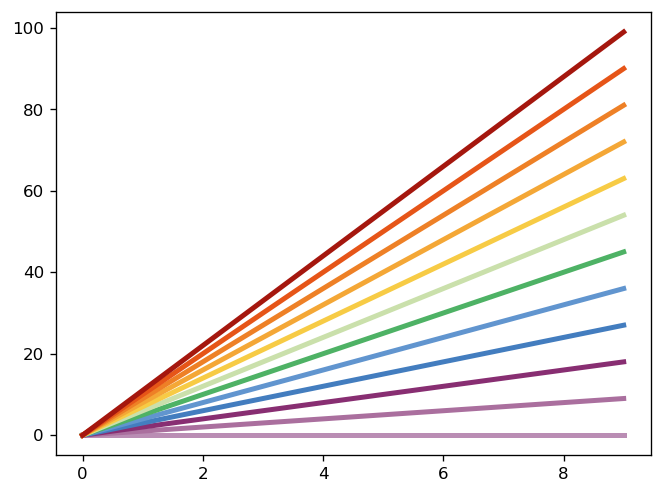

In [ ]:
ps = union_top['all'].param_name.tolist()

# cs = ppe.get_discrete_colors('nipy_spectral', 12, trim=0)

## From Paul Tol, https://personal.sron.nl/~pault
cs = ['#E8ECFB', '#D9CCE3', '#D1BBD7', '#CAACCB', '#BA8DB4',
      '#AE76A3', '#AA6F9E', '#994F88', '#882E72', '#1965B0',
      '#437DBF', '#5289C7', '#6195CF', '#7BAFDE', '#4EB265',
      '#90C987', '#CAE0AB', '#F7F056', '#F7CB45', '#F6C141',
      '#F4A736', '#F1932D', '#EE8026', '#E8601C', '#E65518',
      '#DC050C', '#A5170E', '#72190E', '#42150A']
cs = cs[4::2]

pscs = dict(zip(ps, cs))

for i in range(len(ps)):
    plt.plot(np.arange(10), np.arange(10)*i, c=cs[i], lw=3)

# with open(f'top{len(ps)}_param_colors.pkl', 'wb') as f:
#     pickle.dump(pscs, f)

# !! KILL DASK !!

(don't want to get spammed with PBS emails when the workers time out)

In [54]:
# client.shutdown()
# !rm ./dask-worker.e*
# !rm ./dask-worker.o*